In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import scipy

In [2]:
EuroOptionClean = pd.read_csv(r'C:\Users\HP\Desktop\Fintech\final\final_project\EuropeanOptionCleanData.csv')

EuroOptionClean=EuroOptionClean.drop(columns='Unnamed: 0')
myData=EuroOptionClean.copy()

In [3]:
#myData=myData.drop([245,269,357,648,779,831,834])

#myData.set_index(pd.Index(index))

In [4]:
myData

,currentDate,ExpDate,StrikePrice,Ticker,Type,Last,IV,Chg,StockPrice,T,ImpliedVolatility (caluclated),Difference
0,2/17/2017,3/17/2017,22.5,ARR,Call,0.08,0.13956,-0.01,21.709999,0.076660,0.137428,0.002132
1,2/17/2017,3/17/2017,20.0,ARR,Put,0.20,0.32783,NaN,21.709999,0.076660,0.336280,-0.008450
2,2/17/2017,3/17/2017,180.0,MSG,Put,6.45,0.18380,-0.25,175.300003,0.076660,0.187619,-0.003819
3,2/17/2017,5/19/2017,185.0,MSG,Call,3.10,0.18440,NaN,175.300003,0.249144,0.190170,-0.005770
4,2/17/2017,5/19/2017,170.0,MSG,Put,4.20,0.18729,NaN,175.300003,0.249144,0.191963,-0.004673
...,...,...,...,...,...,...,...,...,...,...,...,...
2266,2/17/2017,5/19/2017,10.0,KPTI,Put,1.35,0.81455,NaN,10.600000,0.249144,0.804735,0.009815
2267,2/17/2017,8/18/2017,22.5,KELYA,Call,1.05,0.19477,NaN,21.990000,0.498289,0.202215,-0.007445
2268,2/17/2017,3/17/2017,5.0,KERX,Call,0.45,0.75406,-0.32,5.060000,0.076660,0.754426,-0.000366
2269,2/17/2017,3/17/2017,5.5,KERX,Call,0.28,0.80470,-0.02,5.060000,0.076660,0.802353,0.002347


In [5]:
Call = myData[myData['Type']=='Call']
Put = myData[myData['Type']=='Put']
Type=myData['Type'].values
S = myData['StockPrice'].values
K = myData['StrikePrice'].values
T = myData['T'].values
P=myData['Last'].values
Vol =myData['IV'].values

Function definition

In [6]:
def OptionValue(S, K, T, r , Type ,sigma):
    
    d1 = (np.log(S /K) + (r + 0.5 * sigma**2) * T )/(sigma * np.sqrt(T))
  
    d2 = (np.log(S /K) + (r - 0.5 * sigma**2) * T )/(sigma * np.sqrt(T))

    if Type == 'Call':
        p = (S * norm.cdf(d1, 0, 1) - K * np.exp(-r * T) * norm.cdf(d2, 0, 1))    
    elif Type == 'Put':
        p = (K*np.exp(-r*T)*norm.cdf(-d2, 0.0, 1.0) - S*norm.cdf(-d1, 0.0, 1.0))
    return p

In [7]:

def vega(S, K, T, sigma, r = 0.03):
    
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    vega = (S * norm.pdf(d1, 0, 1) * np.sqrt(T)) 
    return vega
def vomma(S, K, T, sigma, r = 0.03):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2=d1-sigma*np.sqrt(T)
    vomma=vega(S, K, T, sigma, r = 0.03)*d1*d2/sigma
    return vomma

def Bisection(S,K,T,l,r,rf,price,Type,tol=0.000000000001):
    count=1
    while r-l>tol:
        count=count+1
        mid=float((l+r)/2);
        if OptionValue(S,K,T,rf,Type,mid)>price:
            r=mid
        else:
            l=mid
           
    return l,count


  
def imp_vol_using_Newton(S, K, T, r, Price,Type,e,x0):
    
    count=1
    def newtons_method(S, K, T, r, Price,Type,x0, e):
        global count
        
        count=1
        delta = OptionValue (S,K,T,r,Type,x0) - (Price)
        while delta > e:
            count=count+1
            #print(count)
            x0 = (x0 - (OptionValue (S,K,T,r,Type,x0) - Price)/vega (S,K,T,x0,0.03))
            delta = abs(OptionValue (S,K,T,r,Type,x0) - Price)
        return x0,count
    sig ,count=  newtons_method(S, K, T, r, Price,Type,x0 , e)   
    return sig,count

from scipy import  optimize


def implied_vol_using_blent(S, K, T, r, Price,Type):
    def blent(x0):
        p1=OptionValue (S,K,T,r,Type,x0)-Price
        return p1

    root=optimize.brentq(blent,0.0000001,0.9999999)
    return root

def imp_vol_using_Halley(S, K, T, r, Price,Type,e,x0):
    count=1
    def Halley_method(S, K, T, r, Price,Type,x0, e):
        global count
        count=1
        delta = OptionValue (S,K,T,r,Type,x0) - (Price)
        while delta > e:
            count=count+1
            v=vega(S, K, T, x0, r = 0.03)
            vv=vomma(S, K, T, x0, r = 0.03)
            x0 = x0 - 2*delta*v/(2*v*v-vv*delta)
            delta = abs(OptionValue (S,K,T,r,Type,x0) - Price)
        return x0,count
    sig,count =  Halley_method(S, K, T, r, Price,Type,x0 , e)   
    return sig,count

def Muller(S, K, T, x0, x1, x2, Price, r = 0.03, Type = 'Call'):
    f0 = OptionValue(S, K, T,  r, Type,x0)-Price
    f1 = OptionValue(S, K, T,  r, Type,x0)-Price
    f2 = OptionValue(S, K, T,  r, Type,x0)-Price                
    c = f2
    b = ((x0-x2)**2 * (f1-f2)-(x1-x2)**2 * (f0-f2))/((x0-x2)*(x1-x2)*(x0-x1))
    a = ((x1-x2)*(f0-f2)-(x0-x2)*(f1-f2))/((x0-x2)*(x1-x2)*(x0-x1))
    if ((b-np.sqrt(b**2-4*a*c))>(b+np.sqrt(b**2-4*a*c))):
        x3 = x2-2*c/(b-np.sqrt(b**2-4*a*c))
        return x3
    
    else:
        x3 = x2-2*c/(b+np.sqrt(b**2-4*a*c))
        return x3

def MullerBisection(S, K, T, Xsmall, Xbig, Price, eps, r = 0.03, Type = 'Call'):
    
    count = 1
    while Xbig-Xsmall>eps:
        count = count + 1
        Xmid = float((Xsmall+Xbig)/2);
        XmiddleNew = Muller(S, K, T, Xsmall, Xbig, Xmid, Price, r, Type)
        if OptionValue(S, K, T, r, Type ,Xmid ) > Price:
            Xbig = Xmid
            if (Xsmall < XmiddleNew < Xbig):
            
                Xmiddle = XmiddleNew
            else:
                Xmiddle = (Xsmall+Xbig)/2.0 
        else:
            Xsmall = Xmid
            if (Xsmall < XmiddleNew < Xbig):
                Xmiddle = XmiddleNew 
            else:
                Xmiddle = (Xsmall+Xbig)/2.0
    return  Xsmall,count
    


In [8]:
MullerBisection(S[245], K[245], T[245], 0.000001, 0.99999, P[245], 0.00000000001, 0.03, Type [245])


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:82: RuntimeWarning: divide by zero encountered in double_scalars


(1e-06, 38)

Apply all methods to the whole dataset and get the est sigma


In [9]:
sig_Bisection=[]
sig_Brent=[]
sig_MullerSection=[]
sig_NewTon=[]
sig_Halley=[]
for i in range(len(myData)):
    sig_Bisection.append(Bisection(S[i],K[i],T[i],0.00001,0.99999,0.03,P[i],Type[i],0.000000000001))
    sig_NewTon.append(imp_vol_using_Newton(S[i], K[i], T[i], 0.03, P[i],Type[i],0.000000000001,1))
    sig_MullerSection.append(MullerBisection(S[i], K[i], T[i], 0.00000001, 0.999999, P[i], 0.000000000001, 0.03, Type[i]))
    sig_Halley.append(imp_vol_using_Halley(S[i], K[i], T[i], 0.03, P[i],Type[i],0.000000000001,1))
    
    try:
        
        sig_Brent.append(implied_vol_using_blent(S[i], K[i], T[i], 0.03, P[i],Type[i]))
    except:
        sig_Brent.append(-1)
    

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:82: RuntimeWarning: divide by zero encountered in double_scalars
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in double_scalars
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in double_scalars


In [10]:
sig_new_Newton=[]
sig_new_Halley=[]
for i in range(len(myData)):
    if(sig_Brent[i]==1):
        sig_new_Newton.append(-1)
        sig_new_Halley.append(-1)
    else:
        sig_new_Newton.append(imp_vol_using_Newton(S[i], K[i], T[i], 0.03, P[i],Type[i],0.000000000001,sig_Brent[i]))
        sig_new_Halley.append(imp_vol_using_Halley(S[i], K[i], T[i], 0.03, P[i],Type[i],0.000000000001,sig_Brent[i]))        

In [11]:
pd.DataFrame(sig_Bisection).iloc[:,1]

0       41
1       41
2       41
3       41
4       41
        ..
2266    41
2267    41
2268    41
2269    41
2270    41
Name: 1, Length: 2271, dtype: int64

In [12]:
sig_NewTon

[(0.13273864438271227, 6),
 (0.3412234560295547, 6),
 (0.20113328358443297, 5),
 (0.1797851122456537, 5),
 (0.20442399137175243, 5),
 (0.20652540267958533, 5),
 (0.22107497489372754, 5),
 (0.3316289597174576, 4),
 (0.3215890948474279, 5),
 (0.5514395513529742, 5),
 (0.4606638701372737, 4),
 (0.4532345852915086, 4),
 (0.4449835616801641, 4),
 (0.2355353971268414, 5),
 (0.3316289597174576, 4),
 (0.3215890948474279, 5),
 (0.3316289597174576, 4),
 (0.3215890948474279, 5),
 (0.5514395513529742, 5),
 (0.4606638701372737, 4),
 (0.4532345852915086, 4),
 (0.4449835616801641, 4),
 (0.6017863102582938, 4),
 (0.6742365487870382, 4),
 (0.4246596723003124, 5),
 (0.31828564457230507, 5),
 (0.6029929311546932, 4),
 (0.9581086375875975, 4),
 (0.44057645739700824, 4),
 (0.8216310487724615, 4),
 (0.9041651252028005, 4),
 (0.9288577954310914, 4),
 (0.15060246349144768, 5),
 (0.1586446005432378, 4),
 (0.16928744173294497, 5),
 (0.17647905739984351, 6),
 (0.20692487299687026, 7),
 (0.24903682983918538, 7),


Locate the invalid data

In [13]:
x=[]
for i in range(len(sig_Brent)):
    if sig_Brent[i]==-1:
        x.append(i)
x

[245,
 269,
 357,
 648,
 779,
 833,
 834,
 932,
 967,
 1079,
 1440,
 1615,
 1893,
 1896,
 1902,
 1981,
 2196]

In [14]:
myData.iloc[x,:]

,currentDate,ExpDate,StrikePrice,Ticker,Type,Last,IV,Chg,StockPrice,T,ImpliedVolatility (caluclated),Difference
245,2/17/2017,6/16/2017,775.0,GOOG,Call,58.80,0.11782,NaN,828.070007,0.325804,0.118389,-0.000569
269,2/17/2017,2/24/2017,825.0,GOOGL,Call,21.80,0.10159,4.00,846.549988,0.019165,0.103802,-0.002212
357,2/17/2017,6/16/2017,785.0,GOOGL,Call,66.33,0.11885,NaN,846.549988,0.325804,0.118637,0.000213
648,2/17/2017,1/18/2019,75.0,ADI,Call,9.20,0.08506,NaN,82.480003,1.916496,0.087129,-0.002069
779,2/17/2017,1/18/2019,92.5,ADP,Call,10.85,0.11406,NaN,99.680000,1.916496,0.113260,0.000800
833,2/17/2017,9/15/2017,6.0,BCRX,Put,2.12,1.31231,NaN,6.560000,0.574949,1.317493,-0.005183
834,2/17/2017,9/15/2017,2.0,BDSI,Put,0.62,0.98398,NaN,1.880000,0.574949,0.979752,0.004228
932,2/17/2017,3/17/2017,10.0,CALA,Call,0.90,1.18692,0.30,9.200000,0.076660,1.192867,-0.005947
967,2/17/2017,6/16/2017,55.0,CDW,Call,5.40,0.13518,NaN,59.990002,0.325804,0.141453,-0.006273
1079,2/17/2017,3/3/2017,33.0,CSCO,Call,0.77,0.08481,-0.08,33.740002,0.038330,0.085637,-0.000827


Use nsolve from sympy to get a more accurate implied Volatility

In [15]:
from sympy import nsolve,Symbol
import sympy
vol=Symbol('sigma')
# European call option


#d1=(log(s/k)+(r-d+sigma*sigma/2)*tao)/(sigma*math.sqrt(tao))
#d2=d1-sigma*math.sqrt(tao)

def normcdf(x):
    return (1+sympy.erf(x/sympy.sqrt(2)))/2



def Euro(s,k,sigma,tao,r,d,Type):
    if Type=='Call':
         d1=(sympy.log(s/k)+(r-d+sigma*sigma/2)*tao)/(sigma*sympy.sqrt(tao))
         d2=d1-sigma*sympy.sqrt(tao)
         call=s*sympy.exp(-d*tao)*normcdf(d1)-k*sympy.exp(-r*tao)*normcdf(d2)
            
         return call
    else:
        d1=(sympy.log(s/k)+(r-d+sigma*sigma/2)*tao)/(sigma*sympy.sqrt(tao))
        d2=d1-sigma*sympy.sqrt(tao)
        put=k*sympy.exp(-r*tao)*normcdf(-d2)-s*sympy.exp(-d*tao)*normcdf(-d1)
        return put


ImVol=[]
tag=[]
for i in range(len(myData)):
    try:
        ImVol.append(nsolve(Euro(S[i],K[i],vol,T[i],0.03,0,Type[i])-P[i],vol,1))
    except:
        ImVol.append(str(i)+'--1')

Create a df and drop the invalid rows

In [16]:
#est vol value
sig_Bisection_v=pd.DataFrame(sig_Bisection).iloc[:,0]
sig_Brent_v=pd.DataFrame(sig_Brent).iloc[:,0]
sig_MullerSection_v=pd.DataFrame(sig_MullerSection).iloc[:,0]
sig_NewTon_v=pd.DataFrame(sig_NewTon).iloc[:,0]
sig_Halley_v=pd.DataFrame(sig_Halley).iloc[:,0]
sig_new_Newton_v=pd.DataFrame(sig_new_Newton).iloc[:,0]
sig_new_Halley_v=pd.DataFrame(sig_new_Halley).iloc[:,0]
ImVol_v=pd.DataFrame(ImVol).iloc[:,0]

#steps 
sig_Bisection_s=pd.DataFrame(sig_Bisection).iloc[:,1]
#sig_Brent_s=pd.DataFrame(sig_Brent).iloc[:,0]
sig_MullerSection_s=pd.DataFrame(sig_MullerSection).iloc[:,1]
sig_NewTon_s=pd.DataFrame(sig_NewTon).iloc[:,1]
sig_Halley_s=pd.DataFrame(sig_Halley).iloc[:,1]
sig_new_Newton_s=pd.DataFrame(sig_new_Newton).iloc[:,1]
sig_new_Halley_s=pd.DataFrame(sig_new_Halley).iloc[:,1]
#ImVol_s=pd.DataFrame(ImVol).iloc[:,1]

In [17]:
df_step=pd.DataFrame(list(zip(sig_Bisection_s,sig_MullerSection_s,sig_NewTon_s,sig_Halley_s,sig_new_Newton_s,sig_new_Halley_s)),columns=['Bisection','MullerSection','NewTon','Halley','new_Newton','new_Halley'])
df_step=df_step.drop(x)

idx=pd.Series(list(range(2254)))
df_step=df_step.set_index([idx])
df_step=df_step.drop(1130)
idx=pd.Series(list(range(2253)))
df_step=df_step.set_index([idx])
df_step

,Bisection,MullerSection,NewTon,Halley,new_Newton,new_Halley
0,41,41,6,5,1,1
1,41,41,6,5,1,1
2,41,41,5,4,1,1
3,41,41,5,5,1,1
4,41,41,5,4,1,1
...,...,...,...,...,...,...
2248,41,41,4,3,1,1
2249,41,41,4,4,1,1
2250,41,41,4,3,1,1
2251,41,41,4,4,1,1


In [18]:
df=pd.DataFrame(list(zip(sig_Bisection_v,sig_Brent_v,sig_MullerSection_v,sig_NewTon_v,sig_Halley_v,sig_new_Newton_v,sig_new_Halley_v,ImVol_v)),columns=['Bisection','Brent','MullerSection','NewTon','Halley','new_Newton','new_Halley','ImVol'])
df=df.drop(x)

idx=pd.Series(list(range(2254)))
df=df.set_index([idx])
df=df.drop(1130)
idx=pd.Series(list(range(2253)))
df=df.set_index([idx])
df

,Bisection,Brent,MullerSection,NewTon,Halley,new_Newton,new_Halley,ImVol
0,0.132739,0.132739,0.132739,0.132739,0.132739,0.132739,0.132739,0.132738644382711
1,0.341223,0.341223,0.341223,0.341223,0.341223,0.341223,0.341223,0.341223456029555
2,0.201133,0.201133,0.201133,0.201133,0.201133,0.201133,0.201133,0.201133283584433
3,0.179785,0.179785,0.179785,0.179785,0.179785,0.179785,0.179785,0.179785112245654
4,0.204424,0.204424,0.204424,0.204424,0.204424,0.204424,0.204424,0.204423991371752
...,...,...,...,...,...,...,...,...
2248,0.820999,0.820999,0.820999,0.820999,0.820999,0.820999,0.820999,0.820999374001134
2249,0.182824,0.182824,0.182824,0.182824,0.182824,0.182824,0.182824,0.182824210572376
2250,0.746020,0.746020,0.746020,0.746020,0.746020,0.746020,0.746020,0.746020173737849
2251,0.796214,0.796214,0.796214,0.796214,0.796214,0.796214,0.796214,0.796213529078633


Evaluation

In [19]:
def mse(df):
    
    M=[]
    for j in range(7):  #del last col
        sum=0
        for i in range(len(df)):  
            sum=sum+(df.iloc[i,j]-df.iloc[i,-1])**2
        
        mean=sum/len(df)
        #print(mean)
        M.append(mean)
    return M

import math
def Efficiency(mse,DF_Step):
    meanStep=DF_Step.mean().tolist()
    del mse[1] #delete blent's column,
 
    M=[]
    for i in range(len(mse)):
        M.append(1/((1+mse[i])*math.log2(1+meanStep[i])))
    return M

In [45]:
Mse_ans=mse(df)
# 7 values
Mse_ans


[2.71138015583870e-25,
 1.32853314961418e-26,
 2.75159178888677e-25,
 7.29410522846084e-27,
 1.10227816034781e-27,
 7.58407284211001e-27,
 7.58407284211001e-27]

In [46]:
Mse1=Mse_ans.copy()
#6 values 
effi=Efficiency(Mse1,df_step)

effi

[0.185449023415369,
 0.185449023415369,
 0.373349971502113,
 0.406742462765455,
 0.953196442899999,
 0.953196442899999]

Visualization

In [44]:
Mse=Mse_ans.copy()

Mse

[2.71138015583870e-25,
 1.32853314961418e-26,
 2.75159178888677e-25,
 7.29410522846084e-27,
 1.10227816034781e-27,
 7.58407284211001e-27,
 7.58407284211001e-27]

In [39]:
names=list(df.columns)
names

['Bisection',
 'Brent',
 'MullerSection',
 'NewTon',
 'Halley',
 'new_Newton',
 'new_Halley',
 'ImVol']

<BarContainer object of 6 artists>

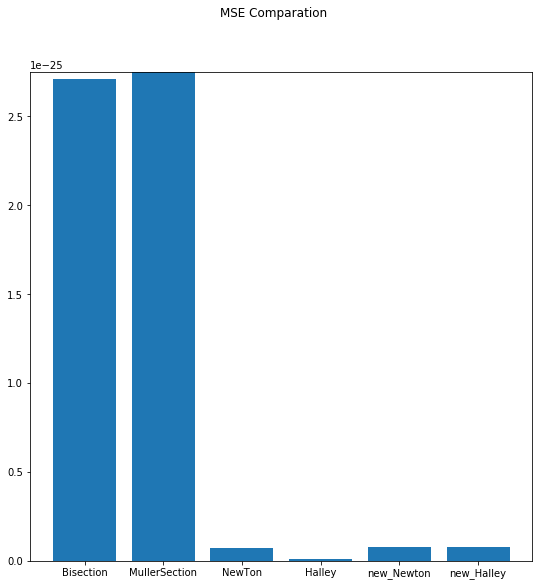

In [40]:
import matplotlib.pyplot as plt
names=list(df.columns)         
del names[-1]
del names[1]

steps=df_step.mean().tolist()     
del Mse[1] #del Brent



values=Mse
plt.figure(figsize=(9, 9))
plt.suptitle('MSE Comparation')

plt.bar(names,values)


<BarContainer object of 6 artists>

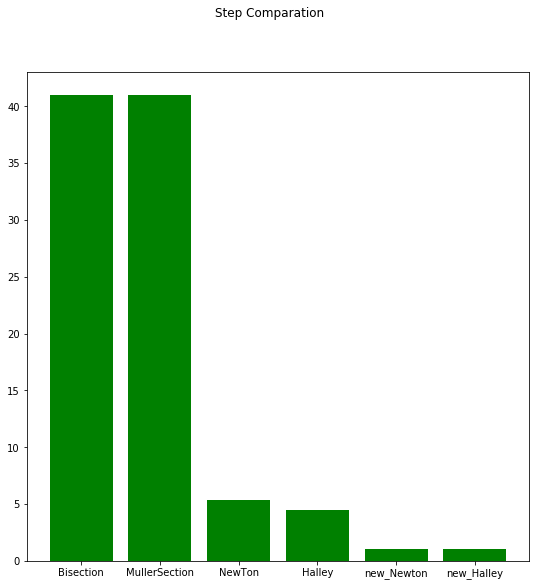

In [43]:
plt.figure(figsize=(9, 9))
plt.suptitle('Step Comparation')
plt.bar(names,steps,color='g')

<BarContainer object of 6 artists>

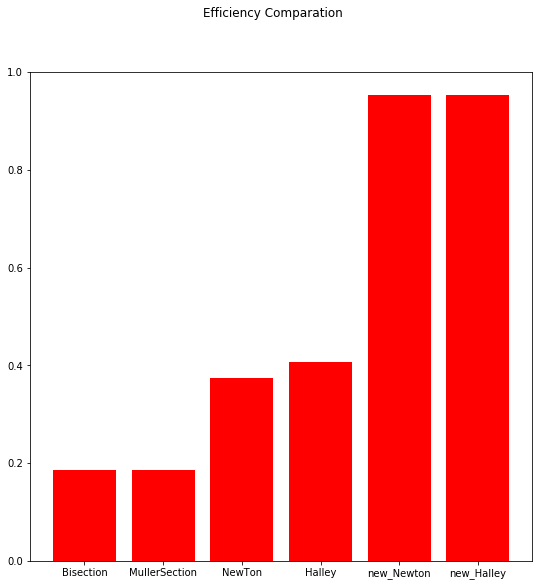

In [34]:

plt.figure(figsize=(9, 9))
plt.suptitle('Efficiency Comparation')
plt.bar(names,effi,color='r')